# Classificador de Spam usando Machine Learning

Este notebook implementa um modelo de classificação de mensagens SMS como spam ou não spam.

**Etapas:**
1. Carregamento dos dados 
2. Análise exploratória 
3. Pré-processamento 
4. Vetorização que transforma texto em dados numéricos
5. Treinamento do modelo com dados numéricos
6. Avaliação e testes

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from deep_translator import GoogleTranslator

nltk.download('stopwords')

sns.set_style('whitegrid')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igorl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Carregamento dos Dados

Nesta etapa utilizo **dados textuais** (mensagens SMS em formato de string). O objetivo é carregar o dataset e preparar as colunas para análise.

In [65]:
df = pd.read_csv('spam.csv', encoding='latin-1')

df = df[['v1', 'v2']]
df.columns = ['categoria', 'mensagem']

print(f'Total de mensagens: {len(df)}')
df.head(10)

Total de mensagens: 5572


,categoria,mensagem
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


## 2. Análise Exploratória

- Distribuição de classes (spam vs não spam)
- Tamanho médio das mensagens
- Padrões visuais nos dados

In [66]:
print('\nDistribuição das categorias:')
print(df['categoria'].value_counts())
print(f'\nPercentual de spam: {(df["categoria"] == "spam").sum() / len(df) * 100:.2f}%')
print(f'Percentual de ham: {(df["categoria"] == "ham").sum() / len(df) * 100:.2f}%')


Distribuição das categorias:
categoria
ham     4825
spam     747
Name: count, dtype: int64

Percentual de spam: 13.41%
Percentual de ham: 86.59%


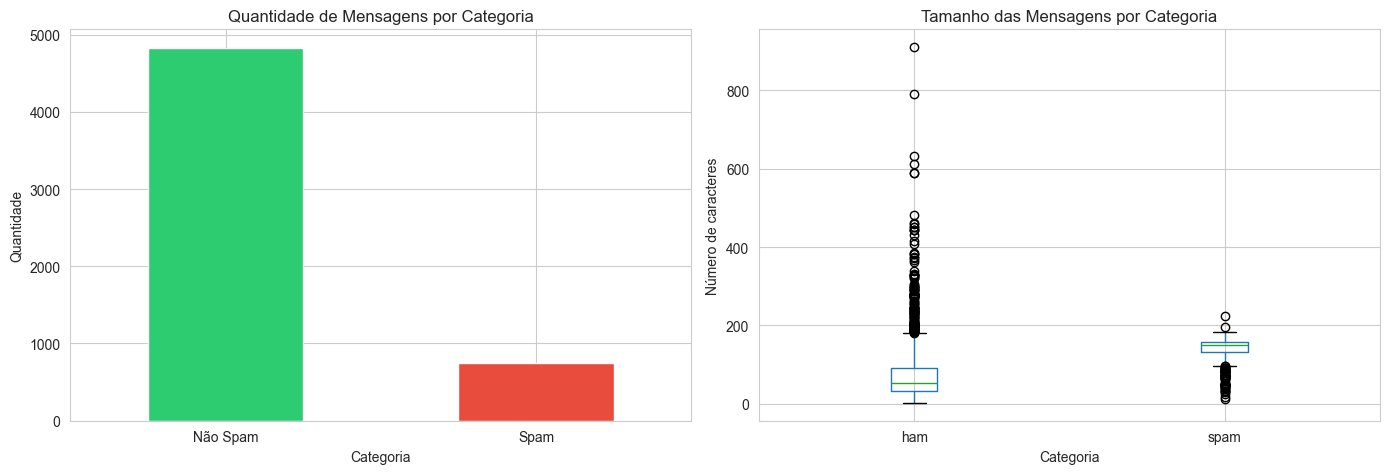

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['categoria'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Quantidade de Mensagens por Categoria')
axes[0].set_xlabel('Categoria')
axes[0].set_ylabel('Quantidade')
axes[0].set_xticklabels(['Não Spam', 'Spam'], rotation=0)

df['tamanho'] = df['mensagem'].apply(len)
df.boxplot(column='tamanho', by='categoria', ax=axes[1])
axes[1].set_title('Tamanho das Mensagens por Categoria')
axes[1].set_xlabel('Categoria')
axes[1].set_ylabel('Número de caracteres')

plt.suptitle('')
plt.tight_layout()
plt.show()

In [68]:
print('\nEstatísticas do tamanho das mensagens:')
print(df.groupby('categoria')['tamanho'].describe())


Estatísticas do tamanho das mensagens:
            count        mean        std   min    25%    50%    75%    max
categoria                                                                 
ham        4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam        747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


## 3. Pré-processamento de Texto

Aqui ocorre a **primeira tokenização** do texto.

**Processo:**
1. `lower()`: Converte para minúsculas
2. `re.sub()`: Remove pontuação e caracteres especiais
3. `split()`: divide texto em lista de palavras
4. Remoção de stopwords (palavras comuns como "the", "is", "a")
5. Stemming: reduz palavras à raiz (ex: "running" → "run")

In [69]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocessar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)
    palavras = texto.split()
    palavras = [stemmer.stem(palavra) for palavra in palavras if palavra not in stop_words]
    return ' '.join(palavras)

df['mensagem_processada'] = df['mensagem'].apply(preprocessar_texto)

print('Exemplo de pré-processamento:')
print(f'\nOriginal: {df.iloc[3]["mensagem"]}')
print(f'\nProcessada: {df.iloc[3]["mensagem_processada"]}')

Exemplo de pré-processamento:

Original: U dun say so early hor... U c already then say...

Processada: u dun say earli hor u c alreadi say


## 4. Preparação dos Dados para Treinamento

### Transformação de Texto em Dados Numéricos



**TfidfVectorizer**:
1. Cria um vocabulário com as 3000 palavras mais importantes
2. Transforma cada mensagem em um vetor numérico de 3000 dimensões
3. Calcula o peso TF-IDF para cada palavra

**TF-IDF = Term Frequency × Inverse Document Frequency**
- Palavras raras mas frequentes na mensagem ganham peso alto
- Palavras comuns em todas mensagens ganham peso baixo

**Exemplo:**
```
Texto: "win free prize now"
Vetor: [0, 0, 0.85, 0, 0.92, 0, 0.73, 0, ...]
              ↑        ↑        ↑
            "win"   "free"  "prize"
```


In [70]:
X = df['mensagem_processada']
y = df['categoria'].map({'ham': 0, 'spam': 1})

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Tamanho do conjunto de treino: {len(X_treino)}')
print(f'Tamanho do conjunto de teste: {len(X_teste)}')
print(f'\nDistribuição no treino:')
print(y_treino.value_counts())
print(f'\nDistribuição no teste:')
print(y_teste.value_counts())

Tamanho do conjunto de treino: 4457
Tamanho do conjunto de teste: 1115

Distribuição no treino:
categoria
0    3859
1     598
Name: count, dtype: int64

Distribuição no teste:
categoria
0    966
1    149
Name: count, dtype: int64


In [71]:
vetorizador = TfidfVectorizer(max_features=3000)

X_treino_tfidf = vetorizador.fit_transform(X_treino)
X_teste_tfidf = vetorizador.transform(X_teste)

print(f'Shape da matriz TF-IDF de treino: {X_treino_tfidf.shape}')
print(f'Shape da matriz TF-IDF de teste: {X_teste_tfidf.shape}')

Shape da matriz TF-IDF de treino: (4457, 3000)
Shape da matriz TF-IDF de teste: (1115, 3000)


## 5. Treinamento do Modelo

O modelo Naive Bayes é treinado com os **dados numéricos** (vetores TF-IDF).

Ele aprende a probabilidade de cada palavra estar associada a spam ou não spam baseado nos padrões numéricos dos dados de treino.

In [72]:
modelo = MultinomialNB()
modelo.fit(X_treino_tfidf, y_treino)

print('Modelo treinado com sucesso!')

Modelo treinado com sucesso!


## 6. Avaliação do Modelo

Aqui testo o modelo com **dados numéricos** nunca vistos (conjunto de teste).

**Métricas:**
- **Acurácia**: % de acertos totais
- **Precisão**: dos que prevemos como spam, quantos realmente eram spam
- **Recall**: de todos os spams reais, quantos conseguimos detectar
- **F1-Score**: média harmônica entre as duas últimas métricas

In [73]:
y_pred_treino = modelo.predict(X_treino_tfidf)
y_pred_teste = modelo.predict(X_teste_tfidf)

print('Desempenho no Treino')
print(f'Acurácia: {accuracy_score(y_treino, y_pred_treino):.4f}')
print(f'Precisão: {precision_score(y_treino, y_pred_treino):.4f}')
print(f'Recall: {recall_score(y_treino, y_pred_treino):.4f}')
print(f'F1-Score: {f1_score(y_treino, y_pred_treino):.4f}')

print('\nDesempenho no Teste')
print(f'Acurácia: {accuracy_score(y_teste, y_pred_teste):.4f}')
print(f'Precisão: {precision_score(y_teste, y_pred_teste):.4f}')
print(f'Recall: {recall_score(y_teste, y_pred_teste):.4f}')
print(f'F1-Score: {f1_score(y_teste, y_pred_teste):.4f}')

Desempenho no Treino
Acurácia: 0.9841
Precisão: 0.9981
Recall: 0.8829
F1-Score: 0.9370

Desempenho no Teste
Acurácia: 0.9695
Precisão: 0.9915
Recall: 0.7785
F1-Score: 0.8722


In [74]:
print('\nRelatório de Classificação:')
print(classification_report(y_teste, y_pred_teste, target_names=['Não Spam', 'Spam']))


Relatório de Classificação:
              precision    recall  f1-score   support

    Não Spam       0.97      1.00      0.98       966
        Spam       0.99      0.78      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



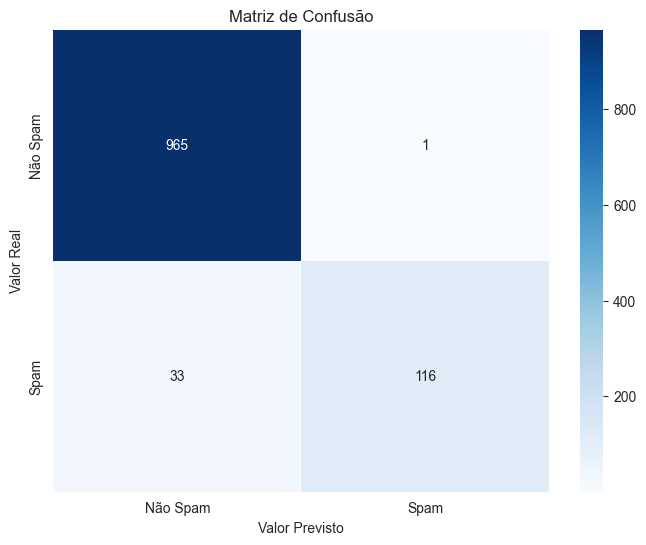


Verdadeiros Negativos: 965
Falsos Positivos: 1
Falsos Negativos: 33
Verdadeiros Positivos: 116


In [75]:
matriz_confusao = confusion_matrix(y_teste, y_pred_teste)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Spam', 'Spam'], 
            yticklabels=['Não Spam', 'Spam'])
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.show()

print(f'\nVerdadeiros Negativos: {matriz_confusao[0, 0]}')
print(f'Falsos Positivos: {matriz_confusao[0, 1]}')
print(f'Falsos Negativos: {matriz_confusao[1, 0]}')
print(f'Verdadeiros Positivos: {matriz_confusao[1, 1]}')

## 7. Análise das Palavras Mais Importantes

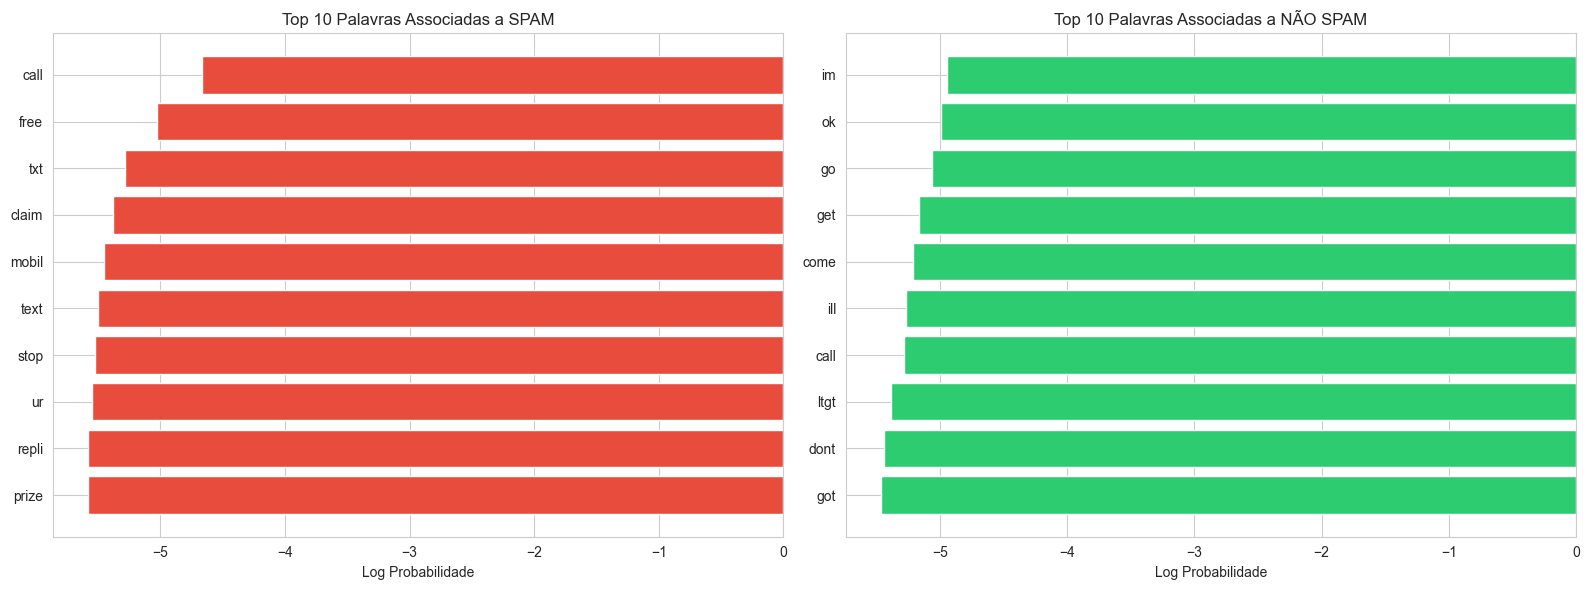

In [76]:
feature_names = vetorizador.get_feature_names_out()
log_prob_spam = modelo.feature_log_prob_[1]
log_prob_ham = modelo.feature_log_prob_[0]

indices_spam = np.argsort(log_prob_spam)[-10:]
indices_ham = np.argsort(log_prob_ham)[-10:]

palavras_spam = [feature_names[i] for i in indices_spam]
palavras_ham = [feature_names[i] for i in indices_ham]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(range(len(palavras_spam)), [log_prob_spam[i] for i in indices_spam], color='#e74c3c')
axes[0].set_yticks(range(len(palavras_spam)))
axes[0].set_yticklabels(palavras_spam)
axes[0].set_xlabel('Log Probabilidade')
axes[0].set_title('Top 10 Palavras Associadas a SPAM')

axes[1].barh(range(len(palavras_ham)), [log_prob_ham[i] for i in indices_ham], color='#2ecc71')
axes[1].set_yticks(range(len(palavras_ham)))
axes[1].set_yticklabels(palavras_ham)
axes[1].set_xlabel('Log Probabilidade')
axes[1].set_title('Top 10 Palavras Associadas a NÃO SPAM')

plt.tight_layout()
plt.show()

## 8. Função para Classificar Novas Mensagens

Esta função recebe **texto** e executa todo o pipeline:
1. Pré-processamento 
2. Vetorização TF-IDF 
3. Predição usando o modelo treinado
4. Retorna classificação e probabilidades

In [77]:
def classificar_mensagem(mensagem):
    mensagem_processada = preprocessar_texto(mensagem)
    mensagem_tfidf = vetorizador.transform([mensagem_processada])
    predicao = modelo.predict(mensagem_tfidf)[0]
    probabilidade = modelo.predict_proba(mensagem_tfidf)[0]
    
    resultado = 'SPAM' if predicao == 1 else 'NÃO SPAM'
    confianca = probabilidade[predicao] * 100
    
    print(f'Mensagem: "{mensagem}"')
    print(f'Classificação: {resultado}')
    print(f'Confiança: {confianca:.2f}%')
    print(f'Probabilidades -> Não Spam: {probabilidade[0]:.4f} | Spam: {probabilidade[1]:.4f}')
    print('-' * 80)
    
    return resultado, confianca

## 9. Testando o Classificador com Novas Mensagens

In [78]:
mensagens_teste = [
    "Congratulations! You've won a free ticket to the Bahamas. Call now!",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT! Your account will be closed. Click here immediately to verify.",
    "Can you pick up some milk on your way home?",
    "You have been selected for a special offer. Text WIN to 12345.",
    "Thanks for your help yesterday, really appreciate it!"
]

print('\nTestando o Classificador')
print()
for msg in mensagens_teste:
    classificar_mensagem(msg)


Testando o Classificador

Mensagem: "Congratulations! You've won a free ticket to the Bahamas. Call now!"
Classificação: SPAM
Confiança: 56.31%
Probabilidades -> Não Spam: 0.4369 | Spam: 0.5631
--------------------------------------------------------------------------------
Mensagem: "Hey, are we still meeting for lunch tomorrow?"
Classificação: NÃO SPAM
Confiança: 99.75%
Probabilidades -> Não Spam: 0.9975 | Spam: 0.0025
--------------------------------------------------------------------------------
Mensagem: "URGENT! Your account will be closed. Click here immediately to verify."
Classificação: SPAM
Confiança: 71.20%
Probabilidades -> Não Spam: 0.2880 | Spam: 0.7120
--------------------------------------------------------------------------------
Mensagem: "Can you pick up some milk on your way home?"
Classificação: NÃO SPAM
Confiança: 98.91%
Probabilidades -> Não Spam: 0.9891 | Spam: 0.0109
--------------------------------------------------------------------------------
Mensagem: "Y

## 10. Testando com Mensagens em Português

Como o modelo foi treinado com mensagens em inglês, precisamos traduzir mensagens em português antes de classificar.

**Pipeline para português:**
1. Mensagem em português (**texto**)
2. Tradução para inglês usando Google Translate (**texto**)
3. Pré-processamento (**texto tokenizado**)
4. Vetorização TF-IDF (**dados numéricos**)
5. Classificação pelo modelo

In [79]:
def traduzir_mensagem(texto, destino='en'):
    try:
        resultado = GoogleTranslator(source='auto', target=destino).translate(texto)
        return resultado
    except Exception as e:
        print(f'Erro na tradução: {e}')
        return texto

In [80]:
mensagens_teste_pt = [
    "Parabéns! Você ganhou um prêmio de R$ 10.000. Ligue agora para resgatar!",
    "Oi, vamos nos encontrar para almoçar amanhã?",
    "URGENTE! Sua conta será bloqueada. Clique aqui imediatamente para verificar.",
    "Pode comprar leite quando estiver voltando para casa?",
    "Você foi selecionado para uma oferta especial. Responda SIM para 40404.",
    "Obrigado pela ajuda ontem, agradeço muito!"
]

print('Classificando Mensagens em Português\n')

for msg_pt in mensagens_teste_pt:
    print(f'Mensagem original (PT): "{msg_pt}"')
    msg_en = traduzir_mensagem(msg_pt, destino='en')
    print(f'Traduzida (EN): "{msg_en}"')
    print()
    classificar_mensagem(msg_en)
    print()

Classificando Mensagens em Português

Mensagem original (PT): "Parabéns! Você ganhou um prêmio de R$ 10.000. Ligue agora para resgatar!"
Traduzida (EN): "Congratulations! You have won a prize of R$10,000. Call now to redeem!"

Mensagem: "Congratulations! You have won a prize of R$10,000. Call now to redeem!"
Classificação: SPAM
Confiança: 88.64%
Probabilidades -> Não Spam: 0.1136 | Spam: 0.8864
--------------------------------------------------------------------------------

Mensagem original (PT): "Oi, vamos nos encontrar para almoçar amanhã?"
Traduzida (EN): "Hi, shall we meet for lunch tomorrow?"

Mensagem: "Hi, shall we meet for lunch tomorrow?"
Classificação: NÃO SPAM
Confiança: 99.57%
Probabilidades -> Não Spam: 0.9957 | Spam: 0.0043
--------------------------------------------------------------------------------

Mensagem original (PT): "URGENTE! Sua conta será bloqueada. Clique aqui imediatamente para verificar."
Traduzida (EN): "URGENT! Your account will be blocked. Click here